# Text2Scene
Dies ist die Lösung der Fingerübung für das Praktikum Text2Scene des Sommersemesters 2021

Autor: Xuan Anh Nguyen <br>
Email: xuananh6077@stud.uni-frankfurt.de

In [142]:
import numpy
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
import spacy
import networkx as nx
import xml.etree.ElementTree as ET
import itertools
import os
import pathlib
import random
from spacy.training import Example
from graphviz import Digraph
from IPython.display import Image


In [2]:
def count_pos(ls):
     x_set = set(ls)
     x_dict = {}

     for entry in x_set:
          x_dict[entry] = ls.count(entry)

     return x_dict

## Aufgabe 2.2 Vorverarbeitung
Einlesen der Trainingsdaten sowie Training des Models mit dem NLP Paket **SpaCy**


In [3]:
# read all valid files used for training

train_data = [] # save only valid data for training (i.e. important tags)
full_data = [] # save all (xml) data
poss_tags = []

root = pathlib.Path().absolute()
for subdir, dirs, files in os.walk(root):
    # skip all hidden directories and files
    files = [f for f in files if not f[0] == '.']
    dirs[:] = [d for d in dirs if not d[0] == '.']
    if not subdir.startswith('.'):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".xml"):
                # filepath will now point towards a valid .xml file
                
                # read and parse xml files
                tree = ET.parse(filepath)
                root = tree.getroot()
                
                full_data.append(root)
                
                # label text with entities 
                entities = []
                for elem in root[1]:
                    # filter non usable entries
                    if (elem.get('start') != None) and (elem.get('end') != None) and (elem.get('start') != '-1') and (elem.get('end') != '-1'):
                        new_ent = (int(elem.get('start')), int(elem.get('end')), elem.tag)
                        entities.append(new_ent)
                    if elem.tag not in poss_tags:
                        poss_tags.append(elem.tag)
                        
                # save the 2 special xml files extra so we can access them easier later
                if filepath.endswith("Bicycles.xml"):
                    print("confirmed")
                    special1 = root
                elif filepath.endswith("Highlights_of_the_Prado_Museum.xml"):
                    print("confirmed")
                    special2 = root

                        
                train_data.append((root[0].text, {'entities': entities}))
    
# print(TRAIN_DATA[1][0])
print(poss_tags)

confirmed
confirmed
['PLACE', 'PATH', 'SPATIAL_ENTITY', 'NONMOTION_EVENT', 'MOTION', 'SPATIAL_SIGNAL', 'MOTION_SIGNAL', 'MEASURE', 'QSLINK', 'OLINK', 'MOVELINK', 'MLINK', 'METALINK', 'MEASURELINK', 'CP', 'URL']


In [4]:
# train the model with our training data

model = "en_core_web_sm"
n_iter = 1000

if model is not None:
    nlp = spacy.load(model) 
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank('en')  
    print("Created blank 'en' model")


if 'ner' not in nlp.pipe_names:
    nlp.add_pipe('ner', last=True)
if 'tok2vec' not in nlp.pipe_names:
    nlp.add_pipe('tok2vec', last=True)
if 'tagger' not in nlp.pipe_names:
    nlp.add_pipe('tagger', last=True)
if 'parser' not in nlp.pipe_names:
    nlp.add_pipe('parser', last=True)
if 'sentencizer' not in nlp.pipe_names:
    nlp.add_pipe('sentencizer', last=True)


ner = nlp.get_pipe('ner')

for _, annotations in train_data:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])
     
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):  # only train NER
    # optimizer = nlp.begin_training()
    for itn in range(n_iter):
        random.shuffle(train_data)
        losses = {}
        doc = nlp.make_doc(root[0].text)
        for text, annotations in train_data:
            try:
                nlp.update(
                    [Example.from_dict(nlp.make_doc(text), annotations)],  
                    drop=0.4,  
                    # sgd=optimizer,
                    losses=losses)
            except:
                pass
        print('\rEpisode {}\tLosses: {:.2f}'.format(itn, losses['ner']), end="")

# nlp.to_disk(root+"/my_model")

Loaded model 'en_core_web_sm'


/home/xa/.local/lib/python3.8/site-packages/spacy/training/iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "

23-Aug-2002 -- On 23-August-2002 at 8 am we left..." with entities "[(1006, 1011, 'PLACE'), (1058, 1063, 'PLACE'), (12...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/home/xa/.local/lib/python3.8/site-packages/spacy/training/iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "
Cartagena and the Colombian Presidential Election..." with entities "[(158, 166, 'PLACE'), (2026, 2032, 'PLACE'), (2080...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/home/xa/.local/lib/python3.8/site-packages/spacy/training/iob_utils.py:139: UserWarning: [W030] Some entities c

Episode 999	Losses: 89.442

In [ ]:
# Alternatively just load pretrained English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

## 2.3 Auswertung

Wie oft kommen welche PoS-Tags vor?

In [5]:
pos = []
for text, _ in train_data:
    doc = nlp(text)
    for token in doc:
        pos.append(token.pos_)
pos = count_pos(pos)
print("Aufgabe 1:")
print(*pos.items(), sep="\n")
    

Aufgabe 1:
('PUNCT', 3508)
('NOUN', 5180)
('ADP', 3105)
('VERB', 2927)
('NUM', 629)
('PRON', 1627)
('SCONJ', 299)
('CCONJ', 826)
('AUX', 897)
('X', 25)
('INTJ', 12)
('PART', 518)
('SPACE', 825)
('SYM', 23)
('DET', 2951)
('ADJ', 1828)
('PROPN', 1927)
('ADV', 1315)


Wie viele [SpatialEntities, Places, Motions, Locations, Signals, QsLinks, OLinks] gibt es?

In [6]:
# From xml data
ents = []
for data in full_data:
    for elem in data[1]:
         ents.append(elem.tag)

ents = count_pos(ents)
print("Aufgabe 2:")
print(*ents.items(), sep="\n")

Aufgabe 2:
('MEASURE', 170)
('URL', 17)
('SPATIAL_ENTITY', 1417)
('CP', 17)
('MOTION', 771)
('METALINK', 1788)
('PLACE', 1852)
('QSLINK', 970)
('OLINK', 244)
('MLINK', 42)
('MEASURELINK', 93)
('PATH', 434)
('MOVELINK', 803)
('NONMOTION_EVENT', 341)
('MOTION_SIGNAL', 526)
('SPATIAL_SIGNAL', 714)


In [7]:
# From processing the texts with spacy, after training with own data
# Not all data could be fed e.g. QSLinks and Olinks
ents2 = []
for text, _ in train_data:
    doc = nlp(text)
    for ent in doc.ents:
         ents2.append(ent.label_)

ents2 = count_pos(ents2)
print("Aufgabe 2:")
print(*ents2.items(), sep="\n")

Aufgabe 2:
('MEASURE', 162)
('SPATIAL_ENTITY', 1326)
('MOTION', 770)
('PLACE', 1600)
('PATH', 406)
('NONMOTION_EVENT', 340)
('MOTION_SIGNAL', 520)
('SPATIAL_SIGNAL', 687)


Wie oft kommen welche QsLink Typen vor? (DC,EC, ...)?

In [8]:
links = []
for data in full_data:
    for elem in data[1]:
        if elem.tag == "QSLINK":
            links.append(elem.get('relType'))
            
links = count_pos(links)
print("Aufgabe 3:")
print(*links.items(), sep="\n")

Aufgabe 3:
('', 2)
('IN', 586)
('NTPP', 42)
('OUT', 3)
('EC', 196)
('TPP', 53)
('DC', 41)
('PO', 12)
('EQ', 35)


Verteilung der Satzlänge graphisch darstellen (x: Satzlänge, y: Wie häufig)?

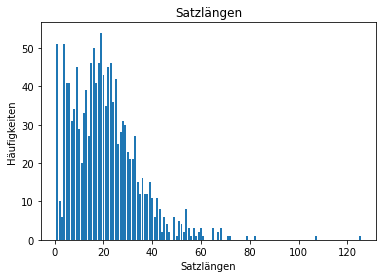

In [9]:
sents = []
for text, _ in train_data:
    doc = nlp(text)
    for sent in doc.sents:
        # find length by counting whitespaces in the sentence
        temp1 = sent.text
        temp2 = temp1.replace(' ', '')
        spaces = len(temp1) - len(temp2)
        sents.append(spaces+1)
# map lengths to amount of times it appereard
distribution = count_pos(sents)
plt.bar(list(distribution.keys()), list(distribution.values()))
plt.title("Satzlängen")
plt.xlabel("Satzlängen")
plt.ylabel("Häufigkeiten")
plt.show()

Welche Links (QSLinks, OLinks) werden von welchen Präpositionen (markiert durch SPATIAL_SIGNAL) getriggert (z.B. wie oft werden QSLinks durch die Präposition „on“ getriggert)?

In [12]:
qs_trigger = []
o_trigger = []

# collect all triggers
for data in full_data:
    temp_qs = []
    temp_o = []
    trigg_dic = {}
    
    # add all triggers ONLY with their id
    for elem in data[1]:
        if elem.tag == "QSLINK":
            temp_qs.append(elem.attrib['trigger'])
        elif elem.tag == "OLINK":
            temp_o.append(elem.attrib['trigger'])
        if elem.tag == "SPATIAL_SIGNAL":
            trigg_dic[elem.get('id')] = elem.get('text')

    # replace trigger id with their respective texts
    for i in range(len(temp_qs)):
        try:
            qs_trigger.append(trigg_dic[temp_qs[i]])
        except:
            pass
    for i in range(len(temp_o)):
        try:
            o_trigger.append(trigg_dic[temp_o[i]])
        except:
            pass

qs_trigger = count_pos(qs_trigger)
qs_trigger = sorted(qs_trigger.items(), key=lambda x: x[1], reverse=True)

o_trigger = count_pos(o_trigger)
o_trigger = sorted(o_trigger.items(), key=lambda x: x[1], reverse=True)

print("Aufgabe 5:")
print("\nQslink trigger:", *qs_trigger, sep="\n")
print("\nOlink trigger:", *o_trigger, sep="\n")

Aufgabe 5:

Qslink trigger:
('in', 228)
('on', 75)
('where', 68)
('at', 54)
('of', 44)
('In', 22)
('with', 15)
('along', 14)
('houses', 11)
('next to', 10)
('full of', 10)
('At', 6)
('between', 5)
('covered', 5)
('On', 4)
('away from', 4)
('through', 4)
('inside', 4)
('connects', 4)
('around', 4)
('contain', 4)
('far from', 3)
('from', 3)
('filled', 3)
('including', 3)
('surrounding', 3)
('to', 2)
('overlooking', 2)
('over', 2)
('atop', 2)
('across', 2)
('has', 2)
('surrounded', 2)
('away', 2)
('outside', 2)
('on top', 2)
('under', 2)
('bordering', 1)
('inside of', 1)
('covering', 1)
('on top of', 1)
('for', 1)
('about', 1)
('into', 1)
('inhabited', 1)
('beside', 1)
('up', 1)
('Along', 1)
('afar', 1)
('after', 1)
('behind', 1)
('adjacent to', 1)
('apart', 1)
('stocked', 1)
('part         of', 1)
('Down', 1)
('packed with', 1)
('restricted', 1)
('line', 1)
('out of', 1)
('apart from', 1)
('upon', 1)
('house', 1)
('surmounted', 1)
('further', 1)
('coiling up', 1)
('In front of', 1)
('up 

Welches sind die fünf häufigsten „MOTION“ Verben (und wie oft kommen diese vor)?

In [13]:
lemma_verbs = []   # only collect lemma from verbs
for data in full_data:
    # collect all different motion verbs
    verbs = []  
    for elem in data[1]:
        if elem.tag == "MOTION":
            verbs.append(elem.attrib['text'])
            
    # only add their lemma to the actual list
    doc = nlp(data[0].text)
    for token in doc:
        if token.text in verbs:
            lemma_verbs.append(token.lemma_)

lemma_verbs = count_pos(lemma_verbs)
lemma_verbs = sorted(lemma_verbs.items(), key=lambda x: x[1], reverse=True)
print("Aufgabe 6:", *lemma_verbs[0:5], sep="\n")

Aufgabe 6:
('bike', 68)
('go', 38)
('visit', 35)
('leave', 32)
('drive', 32)


## 2.4 Visualisierung

Graphische Darstellung von Verbindungen zwischen Entitäten

**Merge Funktion:**<br>
Die Funktion wird rekursiv ausgeführt. Verbinde wenn möglich ein Set mit einem anderen Set. Falls es kein Merge gibt, füge das Set einfach in eine neue Liste hinzu. Falls es einen oder mehrere Merges für das aktuell betrachtete Set gibt, füge nur den Merge der Sets zu der neuen Liste hinzu und entferne alle Sets, welche benutzt wurden aus der alten List. Dadurch wird es keine Dopplungen im weiteren Verlauf geben. Falls ein entferntes Set einen weiteren Merge hätte, der aber nicht ausgeführt wird, da es ja entfernt wurde, so wird dieser Merge im nächsten Rekursionsschritt ausgeführt, da beide Sets in der neuen Liste existieren. Dies wird solange ausgeführt, bis es keine Merges gibt und am Ende wird die Liste mit den ganzen zusammengefassten Sets zurüclgegeben.

In [50]:
def merge_sets(ls):
    """Recursivle merge sets in a given list ls"""
    change = False
    new_ls = []
    i = 0
    while i < len(ls):
        merges = [] # save all merged unions with the current set
        merge_indices = [] # save all indices of set that have been merged with current set
        for j in range(i+1, len(ls)):
            union = set.union(ls[i], ls[j])
            if len(union) < len(ls[i]) + len(ls[j]): # merged
                merges.append(union)
                merge_indices.append(j)
                change = True # if at least on merge has happened, then this step is not the last
                
        # at this point the current set i.e. ls[i] was merged with every possible other set
        if len(merges) == 0:     # no merges 
            new_ls.append(ls[i])
        elif len(merges) == 1:   # exactly 1 merge
            new_ls.append(merges[0])
            ls.pop(merge_indices[0]) # remove the sets that have been merged with current set
        else:                    # 2 or more merges
            temp = merges[0]
            for k in range(1, len(merges)):
                temp = set.union(temp, merges[k])
            for m in range(len(merge_indices)):
                ls.pop(merge_indices[m] - m) # remove the sets that have been merged with current set
            new_ls.append(temp)
            
        i += 1
    if change:
        return merge_sets(new_ls)
    else:
        return ls
    

**Bicycle.xml**

In [200]:
spatial_entity = []
place = []
location = []
path = []
nonmotionevent = []
metalinks = []
qso_links = []

# first get all entities and metalinks
for elem in special1[1]:
    if elem.tag == "SPATIAL_ENTITY":
        spatial_entity.append([elem.get('id'), elem.get('text')])
    elif elem.tag == "PLACE":
        place.append([elem.get('id'), elem.get('text')])
    elif elem.tag == "LOCATION":
        location.append((elem.get('id'), elem.get('text')))
    elif elem.tag == "PATH":
        path.append([elem.get('id'), elem.get('text')])
    elif elem.tag == "NONMOTION_EVENT":
        nonmotionevent.append([elem.get('id'), elem.get('text')])
    elif elem.tag == "METALINK":
        metalinks.append({elem.get('fromID'), elem.get('toID')})
    elif elem.tag == "QSLINK" or elem.tag == "OLINK":
        qso_links.append([elem.get('fromID'), elem.get('toID'), elem.get('relType')])

# merge data
# the easiest way to merge is to use sets, since there cant be duplicates
metalinks = merge_sets(metalinks)
for i in range(len(metalinks)):
    metalinks[i] = list(metalinks[i])  # turn the sets into lists as it is easier to work with from here
    
# remove all entities that have some kind of merge and only keep the ones whose id appears first in a merge list
i = 0
while i < len(spatial_entity):
    change = False
    for j in range(len(metalinks)):
        if (spatial_entity[i][0] in metalinks[j]) and (spatial_entity[i][0] != metalinks[j][-1]):
            spatial_entity.pop(i)
            change = True
            break
    if change:
        continue
    else:   
        i += 1
i = 0
while i < len(place):
    change = False
    for j in range(len(metalinks)):
        if (place[i][0] in place[j]) and (place[i][0] != metalinks[j][-1]):
            place.pop(i)
            change = True
            break
    if change:
        continue
    else:   
        i += 1
i = 0
while i < len(location):
    change = False
    for j in range(len(metalinks)):
        if (location[i][0] in metalinks[j]) and (location[i][0] != metalinks[j][-1]):
            location.pop(i)
            change = True
            break
    if change:
        continue
    else:   
        i += 1
i = 0
while i < len(path):
    change = False
    for j in range(len(metalinks)):
        if (path[i][0] in metalinks[j]) and (path[i][0] != metalinks[j][-1]):
            path.pop(i)
            change = True
            break
    if change:
        continue
    else:   
        i += 1        
i = 0
while i < len(nonmotionevent):
    change = False
    for j in range(len(metalinks)):
        if (nonmotionevent[i][0] in metalinks[j]) and (nonmotionevent[i][0] != metalinks[j][-1]):
            nonmotionevent.pop(i)
            change = True
            break
    if change:
        continue
    else:   
        i += 1     
        
# now change ids in our qslinks and olinks, so when an entity was removed it now points to its merged equivalent
for i in range(len(qso_links)):
    for j in range(len(metalinks)):
        if (qso_links[i][0] in metalinks[j]):
            qso_links[i][0] = metalinks[j][-1]
        if (qso_links[i][1] in metalinks[j]):
            qso_links[i][1] = metalinks[j][-1]
    # replace ids with text, but keep the id if the text is an empty string
    for elem in special1[1]:
        if elem.get('id') == qso_links[i][0] and elem.get('text') != '':
            qso_links[i][0] = elem.get('text')
        if elem.get('id') == qso_links[i][1] and elem.get('text') != '':
            qso_links[i][1] = elem.get('text')

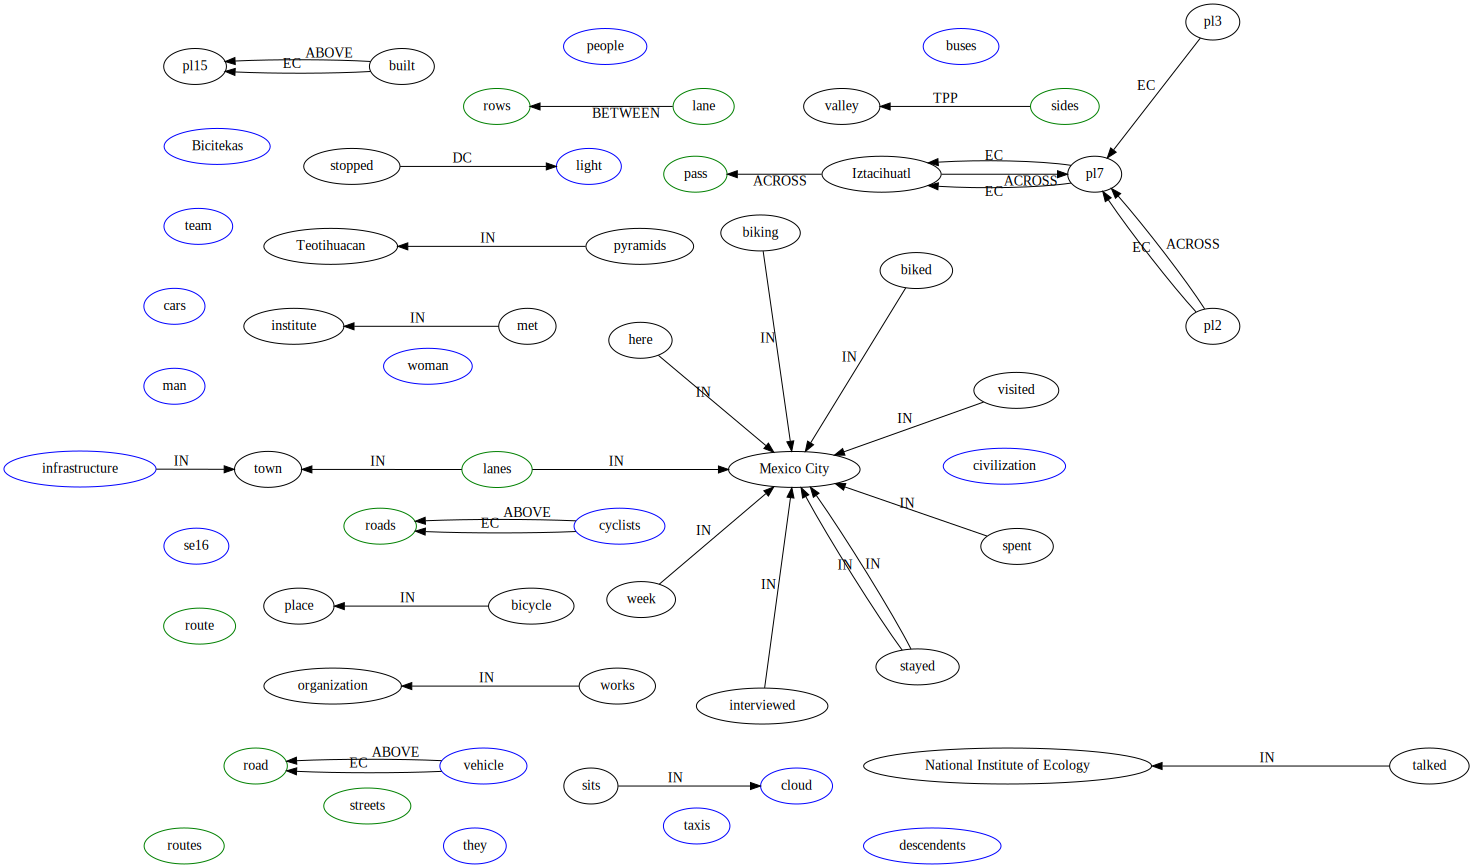

In [202]:
# Create Digraph object
dot = Digraph('dot', filename='bicycle.gv', engine='sfdp')
"""
spatial_entity -> blue
place -> red
location -> yellow
path -> green
nonmotionevent -> black
"""
for item in spatial_entity:
    if item[1] != '':
        dot.node(item[1], color='blue')
    else:
        dot.node(item[0], color='blue')
for item in place:
    if item[1] != '':
        dot.node(item[1], color='red')
    else:
        dot.node(item[0], color='red')
for item in location:
    if item[1] != '':
        dot.node(item[1], color='yellow')
    else:
        dot.node(item[0], color='yellow')
for item in path:
    if item[1] != '':
        dot.node(item[1], color='green')
    else:
        dot.node(item[0], color='green')
for item in nonmotionevent:
    if item[1] != '':
        dot.node(item[1], color='black')
    else:
        dot.node(item[0], color='black')

# Add edges from qso_links
for item in qso_links:
    dot.edge(item[0], item[1], label=item[2])


dot # Visualize the graph in notebook
# dot.view()  # gte a pdf of the graph

**Highlights_of_the_Prado_Museum.xml**

In [205]:
spatial_entity = []
place = []
location = []
path = []
nonmotionevent = []
metalinks = []
qso_links = []
# first get all entities and metalinks
for elem in special2[1]:
    if elem.tag == "SPATIAL_ENTITY":
        spatial_entity.append([elem.get('id'), elem.get('text')])
    elif elem.tag == "PLACE":
        place.append([elem.get('id'), elem.get('text')])
    elif elem.tag == "LOCATION":
        location.append((elem.get('id'), elem.get('text')))
    elif elem.tag == "PATH":
        path.append([elem.get('id'), elem.get('text')])
    elif elem.tag == "NONMOTION_EVENT":
        nonmotionevent.append([elem.get('id'), elem.get('text')])
    elif elem.tag == "METALINK":
        metalinks.append({elem.get('fromID'), elem.get('toID')})
    elif elem.tag == "QSLINK" or elem.tag == "OLINK":
        qso_links.append([elem.get('fromID'), elem.get('toID'), elem.get('relType')])

# merge data
# the easiest way to merge is to use sets, since there cant be duplicates
metalinks = merge_sets(metalinks)
for i in range(len(metalinks)):
    metalinks[i] = list(metalinks[i])  # turn the sets into lists as it is easier to work with from here
    
# remove all entities that have some kind of merge and only keep the ones whose id appears first in a merge list
i = 0
while i < len(spatial_entity):
    change = False
    for j in range(len(metalinks)):
        if (spatial_entity[i][0] in metalinks[j]) and (spatial_entity[i][0] != metalinks[j][-1]):
            spatial_entity.pop(i)
            change = True
            break
    if change:
        continue
    else:   
        i += 1
i = 0
while i < len(place):
    change = False
    for j in range(len(metalinks)):
        if (place[i][0] in place[j]) and (place[i][0] != metalinks[j][-1]):
            place.pop(i)
            change = True
            break
    if change:
        continue
    else:   
        i += 1
i = 0
while i < len(location):
    change = False
    for j in range(len(metalinks)):
        if (location[i][0] in metalinks[j]) and (location[i][0] != metalinks[j][-1]):
            location.pop(i)
            change = True
            break
    if change:
        continue
    else:   
        i += 1
i = 0
while i < len(path):
    change = False
    for j in range(len(metalinks)):
        if (path[i][0] in metalinks[j]) and (path[i][0] != metalinks[j][-1]):
            path.pop(i)
            change = True
            break
    if change:
        continue
    else:   
        i += 1        
i = 0
while i < len(nonmotionevent):
    change = False
    for j in range(len(metalinks)):
        if (nonmotionevent[i][0] in metalinks[j]) and (nonmotionevent[i][0] != metalinks[j][-1]):
            nonmotionevent.pop(i)
            change = True
            break
    if change:
        continue
    else:   
        i += 1     
        
# now change ids in our qslinks and olinks, so when an entity was removed it now points to its merged equivalent
for i in range(len(qso_links)):
    for j in range(len(metalinks)):
        if (qso_links[i][0] in metalinks[j]):
            qso_links[i][0] = metalinks[j][-1]
        if (qso_links[i][1] in metalinks[j]):
            qso_links[i][1] = metalinks[j][-1]
    # replace ids with text, but keep the id if the text is an empty string
    for elem in special2[1]:
        if elem.get('id') == qso_links[i][0] and elem.get('text') != '':
            qso_links[i][0] = elem.get('text')
        if elem.get('id') == qso_links[i][1] and elem.get('text') != '':
            qso_links[i][1] = elem.get('text')

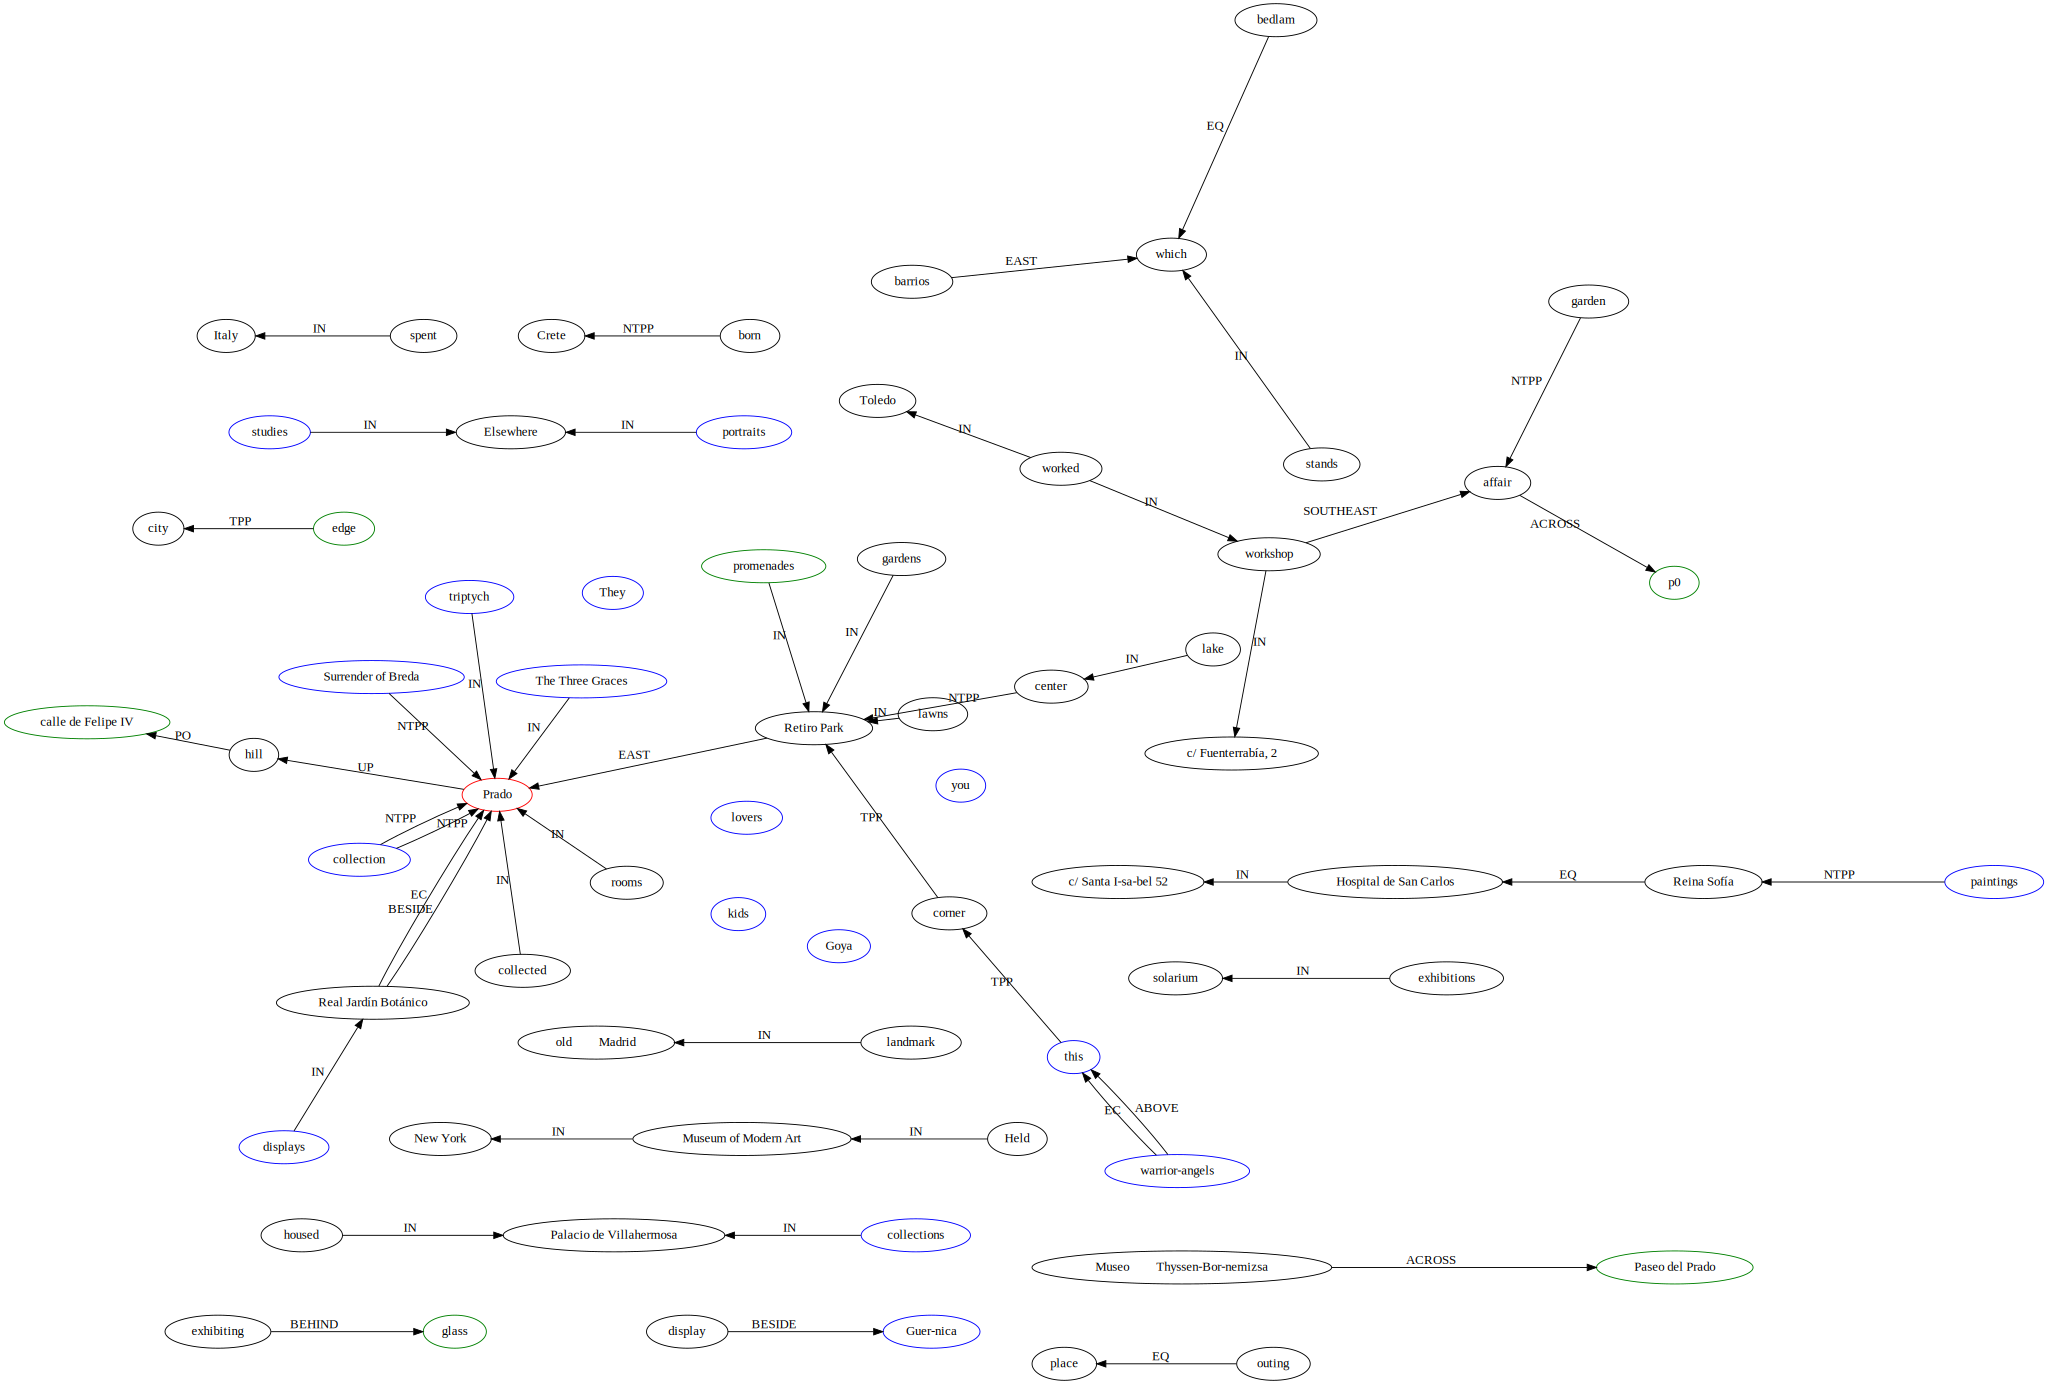

In [206]:
# Create Digraph object
dot = Digraph('dot', filename='museum.gv', engine='sfdp')
"""
spatial_entity -> blue
place -> red
location -> yellow
path -> green
nonmotionevent -> black
"""
for item in spatial_entity:
    if item[1] != '':
        dot.node(item[1], color='blue')
    else:
        dot.node(item[0], color='blue')
for item in place:
    if item[1] != '':
        dot.node(item[1], color='red')
    else:
        dot.node(item[0], color='red')
for item in location:
    if item[1] != '':
        dot.node(item[1], color='yellow')
    else:
        dot.node(item[0], color='yellow')
for item in path:
    if item[1] != '':
        dot.node(item[1], color='green')
    else:
        dot.node(item[0], color='green')
for item in nonmotionevent:
    if item[1] != '':
        dot.node(item[1], color='black')
    else:
        dot.node(item[0], color='black')

# Add edges from qso_links
for item in qso_links:
    dot.edge(item[0], item[1], label=item[2])


dot # Visualize the graph in notebook
# dot.view()  # gte a pdf of the graph